In [1]:
import numpy as np
import torch
import math
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

from Network.simpleCNN import simpleCNN

#### Load pre-trained models

In [2]:
vgg_model = torchvision.models.vgg16(pretrained=True)

In [3]:
cnn_model = simpleCNN(9 * 4 * 4, 64, 32, 10)
cnn_model.load_state_dict(torch.load("Network/cnn_network"))

### Scorecam algorithm


Score cam is implemented in steps, the method can be found in 

https://arxiv.org/pdf/1910.01279.pdf

1. Start by propagating a input image $x$ past the last conv-layer and extract $k$ number of feature maps

2. Upscale those feature maps to the original image size

3. Normalize each mask with $A^k = \frac{A^k_{i,j}}{max(A^k) - min(A^k)}$

4. Project maps to original image and pass thru the network as $f(x \otimes A)$

5. Obtain a weight $w^k$ for each of the masks defined as NN output 

6. Calculate final mask as $c_{final}=ReLU(\sum w^k * A^k)$

In [4]:
def run_cam(model, image, target, verbose=False):
    # No gradients needed
    model.eval()
    image.requires_grad = False
    cnn_network = []
    b_size, _, sx, sy = image.shape
    # Find all the convolutional layers in the network
    for l_name in model._modules:
        layer = model._modules[l_name]
        if isinstance(layer, torch.nn.Sequential):
            for l in layer:
                if isinstance(l, torch.nn.MaxPool2d) or isinstance(l, torch.nn.Conv2d) or isinstance(l, torch.nn.AvgPool2d):
                    cnn_network.append(l)
        elif isinstance(layer, torch.nn.MaxPool2d) or isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.AvgPool2d):
            cnn_network.append(layer)
   
    x = image
    # test_target = labels[image_index].item()

    # 1. Pass input image only thru the convolutional layers
    for layer in cnn_network:
        if isinstance(layer, torch.nn.Conv2d):
            x = F.relu(layer(x))
        else:
            x = layer(x)

    # 2. Interpolate back to the original size         
    x = F.interpolate(x, size=(sx,sy), mode='bilinear', align_corners=False)
    
    if verbose:
        print("Calculating image masks...")
        
    # 3. Normalize each mask
    # 4. Project normalized masks to original image
    _,k,_,_ = x.shape
    masked_images = []
    for i in range(k):
        maxA = max(x[0,i,:].flatten())
        minA = min(x[0,i,:].flatten())
        x[0,i,:] /= (maxA - minA + 1e-4)
        masked_images.append(image * x[:,i,:,:])
    
    if verbose:
        print("Passing masked images trough network...")
        
    # 5. Pass each masks through the original network and calculate score
    weight_scores = []
    for m_img in masked_images:
        out = model(m_img)
        
        # If vgg we need to softmax
        # If our own network, we need to expontiate
        # Fast fix
        if "out" in model._modules:
            out = np.exp(out.detach().numpy())
        else:
            out = F.softmax(out, dim=1).detach().numpy()
        
        weight_scores.append(out[0][target])
    
    if verbose:
        print("Constructing image with the cam...")
        
    # 6. Construct cam-points of interest
    output_img = torch.zeros_like(image)
    for ws, mask in zip(weight_scores, masked_images):
        if not math.isnan(ws):
            output_img += F.relu(mask * ws)
        
    if verbose:
        return masked_images, weight_scores, output_img
    else:
        return output_img


### Test the cam on Mnist digits

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Prep the datasets
trainset = datasets.MNIST('MnistData', download=True, train=True, transform=transform)
image_iter = iter(trainset)

In [6]:
# Pick some mnist image
for _ in range(4):
    image, target = next(image_iter)
# Run the scorecam-algortihm
masked_img, mask_score, mnist_cam = run_cam(cnn_model, image.reshape(1,1,28,28), target, verbose=True)

Calculating image masks...
Passing masked images trough network...
Constructing image with the cam...


#### Model attention

We can hypothyse what the model pays attention to in it's last convolutional layer


The custom MNist network had 9-layers

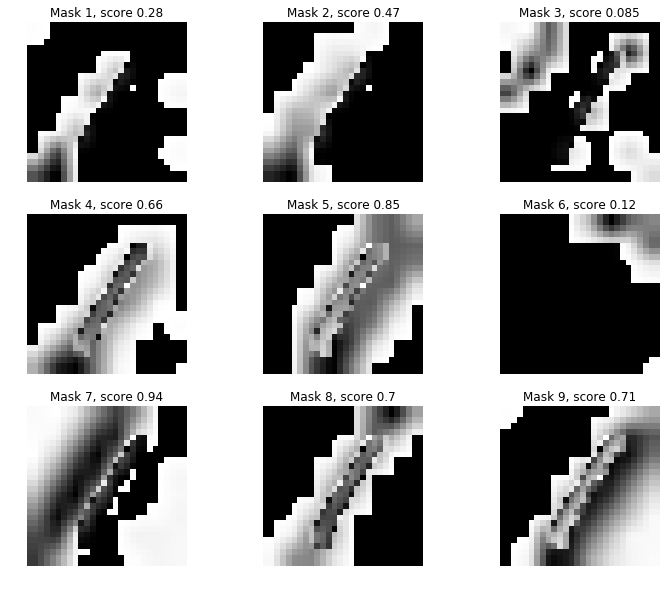

In [7]:
plt.figure(figsize=(12,10))

for i, mask in enumerate(masked_img):
    img_mask = transforms.ToPILImage()((mask).reshape(1,28,28)).convert("RGB")

    plt.subplot(3,3,i+1)
    plt.axis("off")
    plt.title("Mask {}, score {:.2}".format(i+1, mask_score[i]))
    plt.imshow(img_mask)
plt.show()

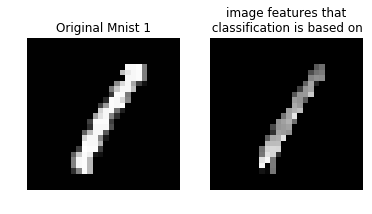

In [8]:
cam_out = transforms.ToPILImage()((mnist_cam).reshape(1,28,28)).convert("RGB")
im_out = transforms.ToPILImage()((image).reshape(1,28,28)).convert("RGB")

plt.figure()
plt.subplot(1,2,1)
plt.title("Original Mnist {}".format(target.item()))
plt.imshow(im_out, cmap="gray_r")
plt.axis("off")
plt.subplot(1,2,2)
plt.title("image features that\n classification is based on")
plt.imshow(cam_out)
plt.axis("off")
plt.show()

### VGG camera for cats/dogs

We can use the VGG16 network that is pre-trained on imagenet to explore similar behaviour on dogs/cats

In [22]:
import PIL
img = PIL.Image.open('MnistDATA/persian_cat.jpg')
img = img.resize((240,240))
img = np.array(img)[...,::-1]/255.0
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)


X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [23]:
# arg 283 equals a persian cat
masked_cats, cat_mask_score, vgg_cat_mask = run_cam(vgg_model, X, torch.tensor(283), verbose=True)

Calculating image masks...
Passing masked images trough network...
Constructing image with the cam...


9 Highest scoring image masks


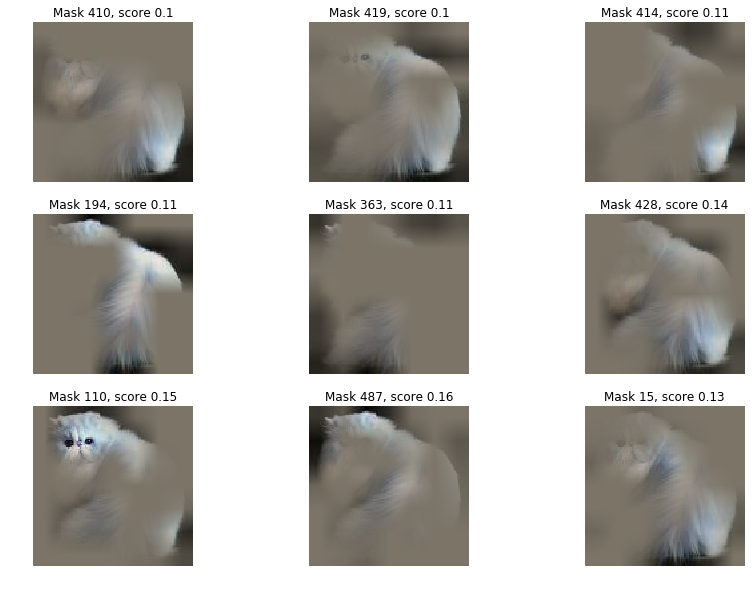

In [24]:
n_screens = 9
max_args = np.argpartition(cat_mask_score, -n_screens)[-n_screens:]

print("{} Highest scoring image masks".format(n_screens))
plt.figure(figsize=(14,10))
for i, ind in enumerate(max_args):
    img_and_mask = transforms.ToPILImage()((masked_cats[ind] * std + mean).reshape(3,240,240)).convert("RGB")

    # print(masked_cats[ind].detach().numpy().shape)
    plt.subplot(3,int(n_screens/3),i+1)
    plt.title("Mask {}, score {:.2}".format(ind, cat_mask_score[ind].item()))
    plt.axis("off")
    plt.imshow(img_and_mask)
    
plt.show()


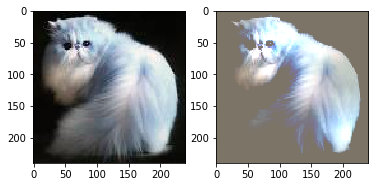

In [29]:
# img = transforms.ToPILImage()(vgg_cat_out[0]).convert("RGB")
masked_img = transforms.ToPILImage()(torch.clamp(vgg_cat_mask * std + mean, 0, 1).reshape(3,240,240)).convert("RGB")

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(masked_img)
plt.show()

In [9]:
import PIL
img = PIL.Image.open('MnistDATA/catdog.jpg')
img = img.resize((240,240))
img = np.array(img)[...,::-1]/255.0
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)


X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [10]:
# vgg_out = vgg_model(torch.FloatTensor(X).reshape(1,3,240,240))

In [11]:
# 286 = egyptian cat
masked_cats, cat_mask_score, vgg_cat_mask = run_cam(vgg_model, X, torch.tensor(286), verbose=True)
# vgg_cat_mask = run_cam(vgg_model, X, torch.tensor(286), verbose=False)

Calculating image masks...
Passing masked images trough network...
Constructing image with the cam...


3 Highest scoring image masks


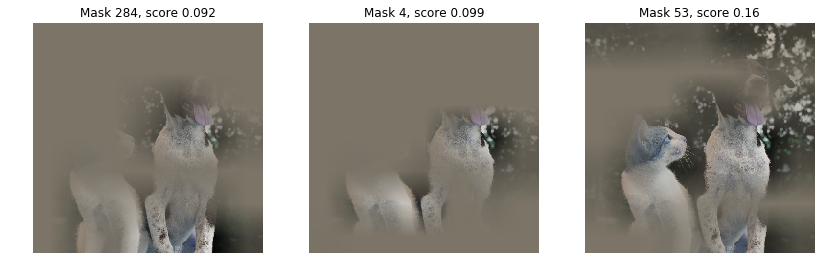

In [12]:
n_screens = 3
max_args = np.argpartition(cat_mask_score, -n_screens)[-n_screens:]

print("{} Highest scoring image masks".format(n_screens))
plt.figure(figsize=(14,10))
for i, ind in enumerate(max_args):
    img_and_mask = transforms.ToPILImage()((masked_cats[ind] * std + mean).reshape(3,240,240)).convert("RGB")

    plt.subplot(1,n_screens,i+1)
    plt.title("Mask {}, score {:.2}".format(ind, cat_mask_score[ind].item()))
    plt.axis("off")
    plt.imshow(img_and_mask)

In [13]:
# 198 = Spaniel dog
masked_dogs, dog_mask_score, vgg_dog_mask = run_cam(vgg_model, X, torch.tensor(198), verbose=True)
# vgg_dog_mask = run_cam(vgg_model, X, torch.tensor(198), verbose=False)

Calculating image masks...
Passing masked images trough network...
Constructing image with the cam...


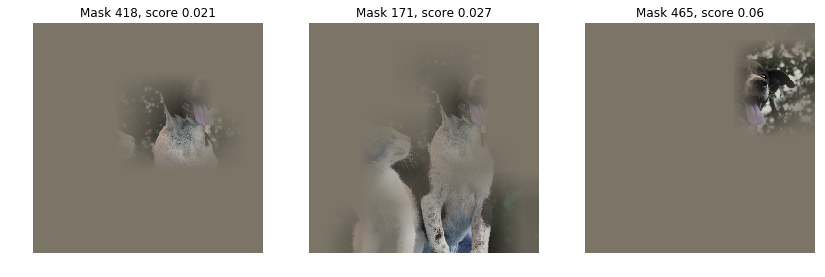

In [14]:
n_screens = 3
max_args = np.argpartition(dog_mask_score, -n_screens)[-n_screens:]
plt.figure(figsize=(14,10))
for i, ind in enumerate(max_args):
    img_and_mask = transforms.ToPILImage()((masked_dogs[ind] * std + mean).reshape(3,240,240)).convert("RGB")

    plt.subplot(1,n_screens,i+1)
    plt.title("Mask {}, score {:.2}".format(ind, dog_mask_score[ind].item()))
    plt.axis("off")
    plt.imshow(img_and_mask)
        
plt.show()

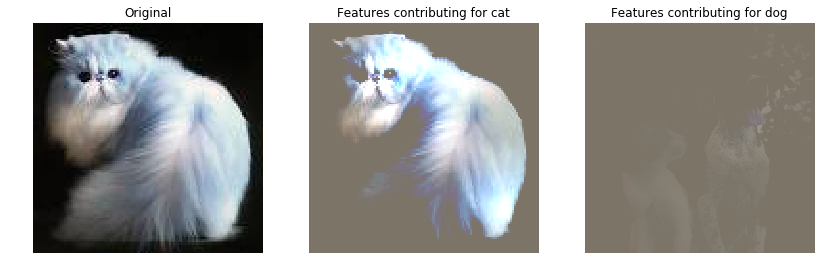

In [34]:
masked_cat_img = transforms.ToPILImage()(torch.clamp(vgg_cat_mask * std + mean, 0, 1).reshape(3,240,240)).convert("RGB")
masked_dog_img = transforms.ToPILImage()(torch.clamp(vgg_dog_mask * std + mean, 0, 1).reshape(3,240,240)).convert("RGB")


plt.figure(figsize=(14,10))
plt.subplot(1,3,1)
plt.title("Original")
plt.axis("off")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title("Features contributing for cat")
plt.axis("off")
plt.imshow(masked_cat_img)

plt.subplot(1,3,3)
plt.title("Features contributing for dog")
plt.axis("off")
plt.imshow(masked_dog_img)

plt.show()